# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pathlib

import tensorflow as tf
from tensorflow import keras

import struct
from array import array

import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2023-01-16 20:03:47.699424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 20:03:48.174658: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-16 20:03:48.920403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11/lib64:
2023-01-16 20:03:48.920469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

# Load in Data as Numpy arrays

Data loader class, since it's stored in an idx file format

In [2]:
#
# MNIST Data Loader Class, stole this from the internet
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.asarray(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

Load data

In [3]:
#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = 'data/train/images/train-images.idx3-ubyte'
training_labels_filepath = 'data/train/labels/train-labels.idx1-ubyte'
test_images_filepath = 'data/test/images/t10k-images.idx3-ubyte'
test_labels_filepath = 'data/test/labels/t10k-labels.idx1-ubyte'

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

Verify data loaded

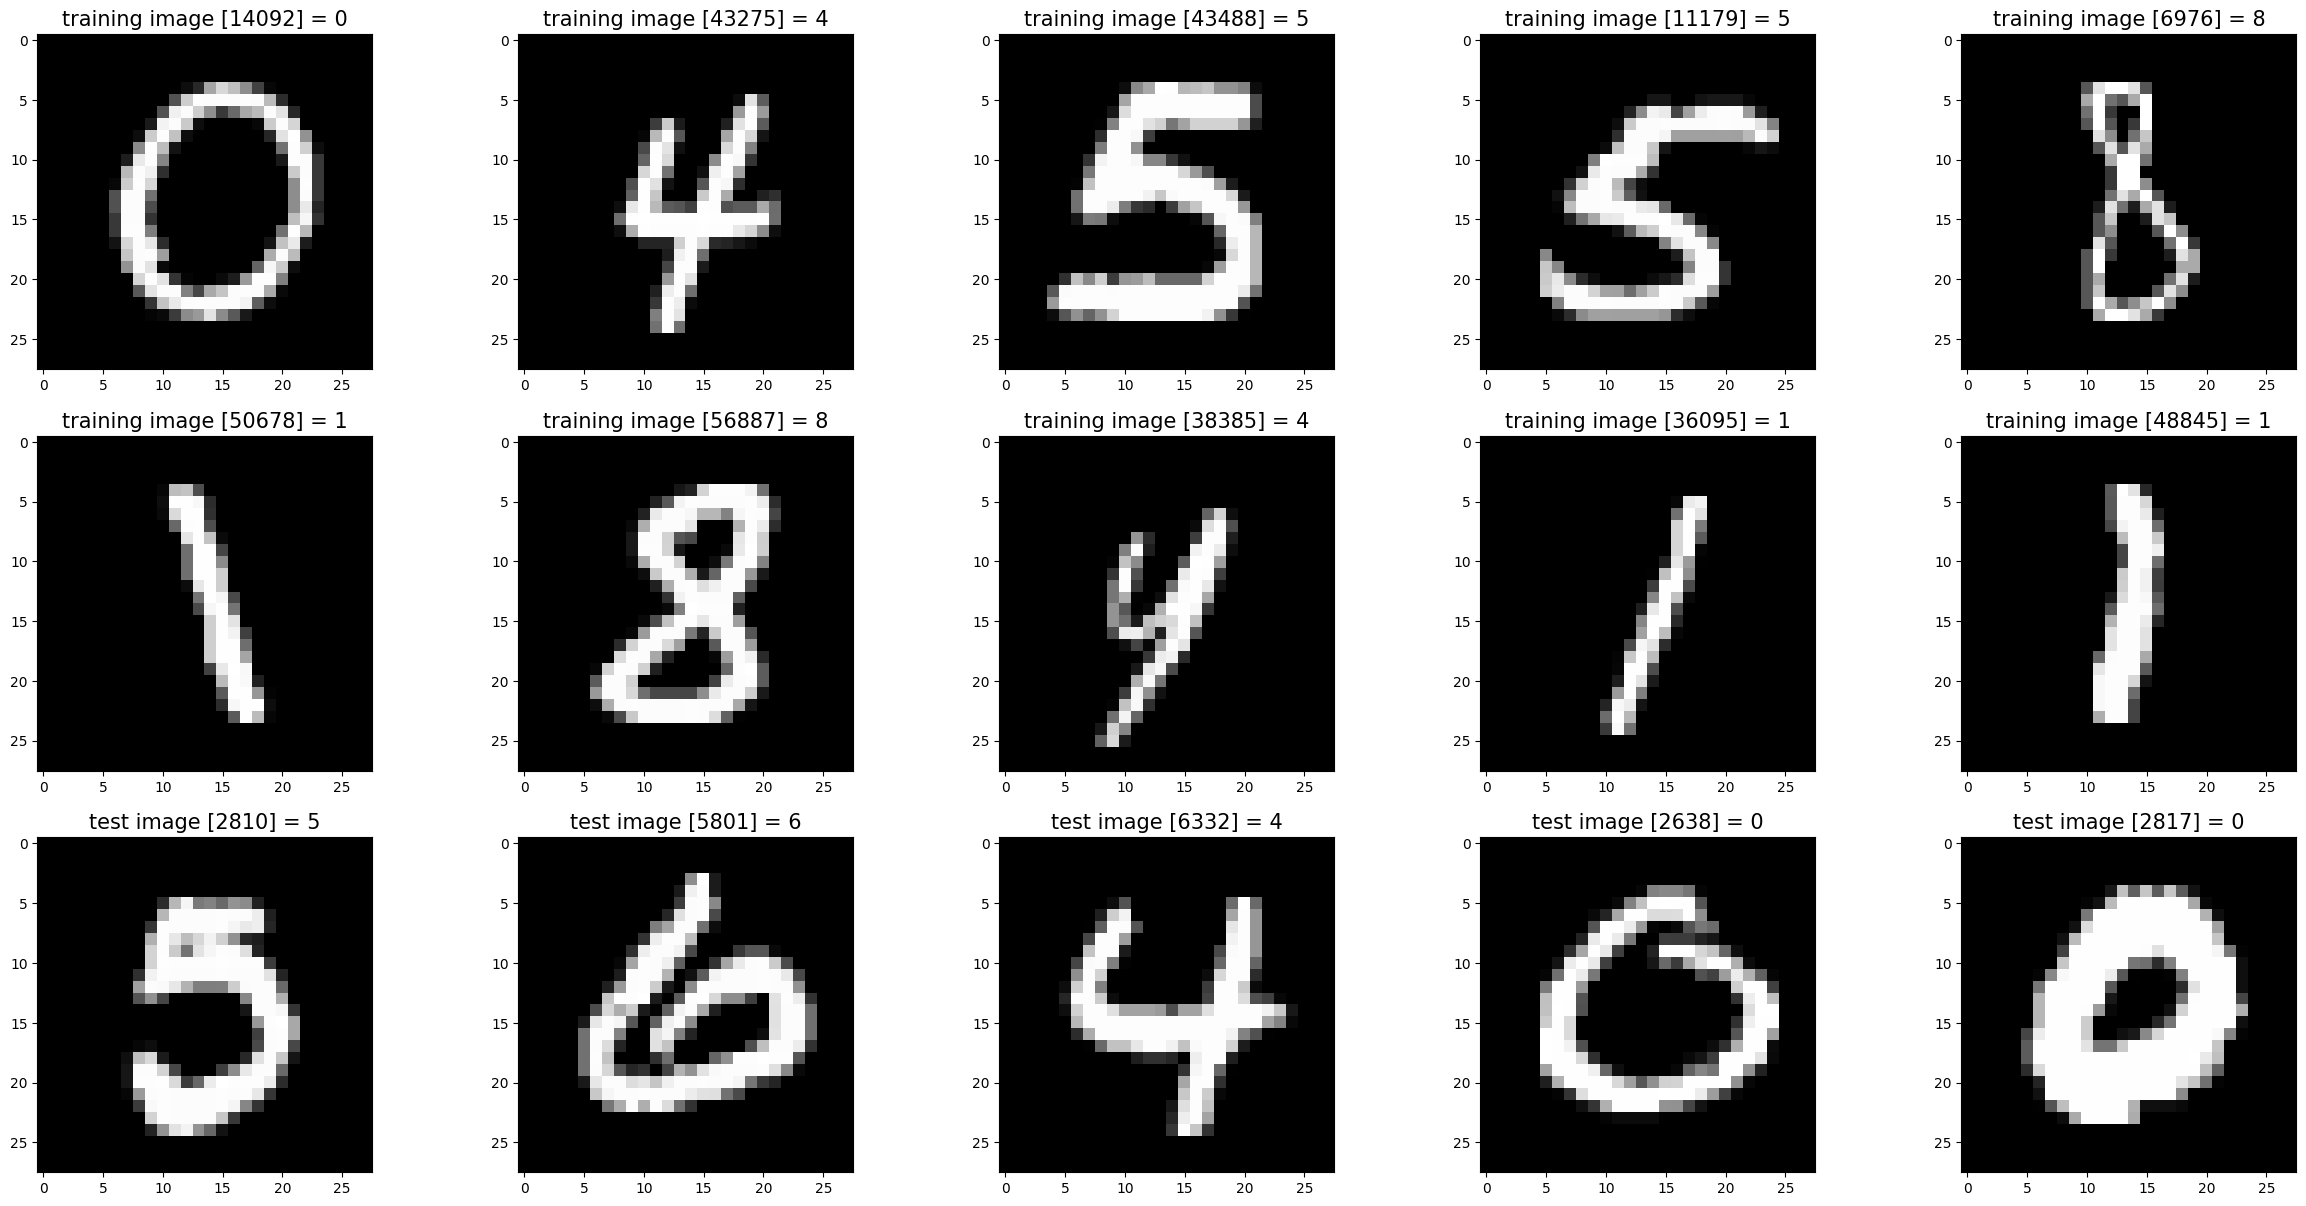

In [4]:
#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

# Model Definition

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation = 'relu', input_shape = (28, 28)),
  tf.keras.layers.Dense(200, activation = 'relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(480, activation = 'relu'),
  tf.keras.layers.Dense(100, activation = 'relu'),
  tf.keras.layers.Dense(10, activation='sigmoid', name = 'output')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28, 32)            928       
                                                                 
 dense_1 (Dense)             (None, 28, 200)           6600      
                                                                 
 flatten (Flatten)           (None, 5600)              0         
                                                                 
 dense_2 (Dense)             (None, 480)               2688480   
                                                                 
 dense_3 (Dense)             (None, 100)               48100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 2,745,118
Trainable params: 2,745,118
Non-

2023-01-16 20:03:53.258646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 20:03:53.430867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 20:03:53.431028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 20:03:53.431816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Training the model

In [6]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
 117/1875 [>.............................] - ETA: 2s - loss: 10.2652 - accuracy: 0.7278 

2023-01-16 20:03:56.060629: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1875/1875 [==============================] - 4s 1ms/step - loss: 0.8915 - accuracy: 0.9199
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1109 - accuracy: 0.9661
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0901 - accuracy: 0.9723
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0780 - accuracy: 0.9762
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0675 - accuracy: 0.9790
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0489 - accuracy: 0.9849
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0530 - accuracy: 0.9848
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0391 - accuracy: 0.9892
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0378 - accuracy: 0.9895
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0320 - accurac

# Evaluating the model

In [7]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.1600 - accuracy: 0.9724


[0.15996237099170685, 0.9724000096321106]